# Test runtime of guide star selection

**Context:** The guide star selection code was initilly written to pre-select guide stars for all Pasiphae survey fields. However, due to pointing inaccuracies, the pre-selected guide stars may not actually fall into the guide camera. Instead of a pointing correction which is time consuming, we decided to accept pointing inaccuracies, which we expect not to have a significant impact on the science case. However, this means that the pre-selection of guide stars does not work and we have to do it on-the-fly. This is a two step process after the telescope reached its position:
1. Take an exposure, then resolve the WCS to find the actual position.
2. Identify guide stars for that exact position.

John is working in step 1. The guide star selection code is used for step 2.

**Questions:**
1. How much time does it take to identify guide stars for a specific position?
1. How much memory space does the selector require with all pre-loaded Gaia stars?
1. Is this feasible?

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from astropy.coordinates import Angle, SkyCoord
import astropy.units as u
from astropy.io.votable import parse
from datetime import datetime
import numpy as np
import os
from pandas import DataFrame
import seaborn as sns
import sys

from fieldgrid import FieldGridIsoLat
from guidestars import GuideStarWalopN, GuideStarWalopS, load_gaia
from utilities import cart_to_sphere

## Sampling functions

Based on the methods in `fieldgrid.py`:

In [37]:
def in_galactic_plane(gal_lat_lim, ra, dec):
        """Check which fields are located within the Galactic latitude limits.

        Parameters
        ----------
        gal_lat_lim : float
            Galactic latitude limit in radians. If the limit is X, fields with
            Galactic latitude in [-X, X] are flagged.
        ra : np.ndarray
            Field center right ascensions in radians. The default is None
        dec : np.ndarray
            Field center declinations in radians. The default is None

        Returns
        -------
        np.ndarray
            Boolean array. Fields within the Galactic plane limits are marked
            as True, otherwise as False.
        """

        # stop if Galactic latitude limit is 0:
        if not gal_lat_lim:
            return np.zeros(n_fields, dtype=bool)

        # check:
        coord = SkyCoord(ra, dec, unit='rad', frame='icrs')
        coord = coord.transform_to('galactic')
        sel = np.logical_and(
                coord.b.rad < gal_lat_lim,
                coord.b.rad > -gal_lat_lim)

        return sel

In [38]:
def sample_spherical(n_points, dec_lim_north=np.pi/2, dec_lim_south=-np.pi/2, gal_lat_lim=0):
    """Draw random samples uniformly over the sky.

    Parameters
    ----------
    n_points : int
        Number of random samples.
    dec_lim_north : float, optional
        Northern declination limit in radian. The default is np.pi/2.
    dec_lim_south : float, optional
        Southern declination limit in radian. The default is -np.pi/2.
    gal_lat_lim : float, optional
        Galactic latitude limit in radians. If the limit is X, points with
        Galactic latitude in [-X, X] are excluded. The default is 0.

    Returns
    -------
    ra : np.ndarray
        Right ascensions of the randomly samples points in radians.
    dec : np.ndarray
        Declinations of the randomly samples points in radians.
    """

    ra = []
    dec = []
    n_needed = n_points

    while True:
        vec = np.random.randn(3, n_points)
        vec /= np.linalg.norm(vec, axis=0)
        more_ras, more_decs = cart_to_sphere(vec[0], vec[1], vec[2])
        sel = np.logical_and(more_decs >= dec_lim_south, more_decs <= dec_lim_north)
        more_ras = more_ras[sel]
        more_decs = more_decs[sel]
        sel = in_galactic_plane(gal_lat_lim, more_ras, more_decs)
        more_ras = more_ras[~sel][:n_needed]
        more_decs = more_decs[~sel][:n_needed]
        ra.append(more_ras)
        dec.append(more_decs)
        n_needed -= more_ras.shape[0]

        if n_needed < 1:
            break

    ra = np.concatenate(ra)
    dec = np.concatenate(dec)

    return ra, dec

## WALOP-S

### Set up guide star selector

In [39]:
selector = GuideStarWalopS()

Set parameters:

In [40]:
selector.load_params('guide_walop_s.json')

Parameters loaded from guide_walop_s.json.


Read in Gaia stars:

In [41]:
dir_in = 'gaia/'
votable_files = [
        'gaia_g_mag12_b28.vot', 'gaia_g_mag12-13_b28.vot', 'gaia_g_mag13-14_b28.vot']

gaia_ra, gaia_dec, gaia_mag = load_gaia(votable_files, dir_in=dir_in, dec_uplim=1)
print('# stars:', gaia_mag.shape[0])

Read VOTable 1/3..
Read VOTable 2/3..
Read VOTable 3/3..
# stars: 1818306


Separate bright stars:

In [42]:
gaia_mag_limit = 7
sel = gaia_mag < gaia_mag_limit
gaia_bright_ra = gaia_ra[sel]
gaia_bright_dec = gaia_dec[sel]
gaia_ra = gaia_ra[~sel]
gaia_dec = gaia_dec[~sel]
gaia_mag = gaia_mag[~sel]
print(f'{np.sum(sel)} bright stars separated.')

4383 bright stars separated.


Add bright stars that should be avoided:

In [43]:
selector.set_stars_to_avoid(np.radians(gaia_bright_ra), np.radians(gaia_bright_dec))

4383 coordinates of bright stars set that will be avoided in the guide camera.


Add stars:

In [44]:
selector.set_stars(np.radians(gaia_ra), np.radians(gaia_dec), gaia_mag)

1813923 candidate stars added.
Magnitude range: 7.0 - 14.0


How much memory do the stars' coordinates and matnitudes require?

In [45]:
memory_byte = sys.getsizeof(gaia_ra) + sys.getsizeof(gaia_dec) + sys.getsizeof(gaia_mag) \
        + sys.getsizeof(gaia_bright_ra) + sys.getsizeof(gaia_bright_dec)

In [46]:
print(f'MB: {memory_byte/1000000:.1f}') 

MB: 36.3


In [47]:
del gaia_ra, gaia_dec, gaia_mag, gaia_bright_ra, gaia_bright_dec

Magnitude to exposure time conversion function:

In [48]:
mag_ref = 16
exp_ref = 5 # sec
exp_min = 1 # sec
mag_to_exp = lambda mag: np.maximum(exp_ref * 10**((mag - mag_ref) / 2.5), exp_min)

### Test

Sample test points:

In [49]:
n_points = 100
test_ra, test_dec = sample_spherical(n_points, dec_lim_north=0, gal_lat_lim=np.radians(30))

Run test:

In [50]:
runtime = []
n_guidestars = []

for i, (ra, dec) in enumerate(zip(test_ra, test_dec)):
    print(f'\rProgress: {i*100/n_points:.1f}%', end='')
    runtime_start = datetime.now()
    guidestars = selector.select(field_ra=ra, field_dec=dec, mag_to_exp=mag_to_exp, return_coord=False)
    runtime.append((datetime.now() - runtime_start).total_seconds())
    n_guidestars.append(len(guidestars))
    
results = DataFrame({'runtime (s)': runtime, 'n_guidestars': n_guidestars})
del runtime, n_guidestars
print('\rProgress: done.     ')

Progress: done.     


### Results

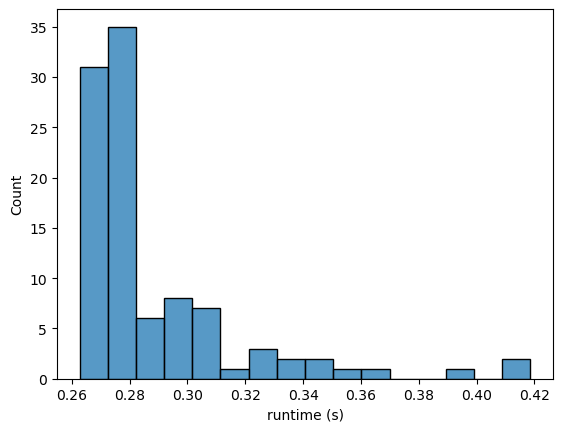

In [51]:
sns.histplot(data=results, x='runtime (s)');

In [52]:
results.describe()

,runtime (s),n_guidestars
count,100.000000,100.0
mean,0.288625,3.0
std,0.030374,0.0
min,0.262683,3.0
25%,0.271090,3.0
50%,0.276231,3.0
75%,0.294181,3.0
max,0.418621,3.0


## WALOP-N

### Set up guide star selector

In [53]:
selector = GuideStarWalopN()

Set parameters:

In [54]:
selector.load_params('guide_walop_n.json')

Parameters loaded from guide_walop_n.json.


Read in Gaia stars:

In [55]:
dir_in = 'gaia/'
votable_files = [
        'gaia_g_mag12_b28.vot', 'gaia_g_mag12-13_b28.vot', 'gaia_g_mag13-14_b28.vot', 'gaia_g_mag14-14.5_b28.vot',
        'gaia_g_mag14.5-15_b28.vot', 'gaia_g_mag15-15.4_b28.vot']

gaia_ra, gaia_dec, gaia_mag = load_gaia(votable_files, dir_in=dir_in, dec_lolim=-1)
print('# stars:', gaia_mag.shape[0])

Read VOTable 1/6..
Read VOTable 2/6..
Read VOTable 3/6..
Read VOTable 4/6..
Read VOTable 5/6..
Read VOTable 6/6..
# stars: 3790594


Separate bright stars:

In [56]:
gaia_mag_limit = 7
sel = gaia_mag < gaia_mag_limit
gaia_bright_ra = gaia_ra[sel]
gaia_bright_dec = gaia_dec[sel]
gaia_ra = gaia_ra[~sel]
gaia_dec = gaia_dec[~sel]
gaia_mag = gaia_mag[~sel]
print(f'{np.sum(sel)} bright stars separated.')

4147 bright stars separated.


Add bright stars that should be avoided:

In [57]:
selector.set_stars_to_avoid(np.radians(gaia_bright_ra), np.radians(gaia_bright_dec))

4147 coordinates of bright stars set that will be avoided in the guide camera.


Add stars:

In [58]:
selector.set_stars(np.radians(gaia_ra), np.radians(gaia_dec), gaia_mag)

3786447 candidate stars added.
Magnitude range: 7.0 - 15.4


How much memory do the stars' coordinates and matnitudes require?

In [59]:
memory_byte = sys.getsizeof(gaia_ra) + sys.getsizeof(gaia_dec) + sys.getsizeof(gaia_mag) \
        + sys.getsizeof(gaia_bright_ra) + sys.getsizeof(gaia_bright_dec)

In [60]:
print(f'MB: {memory_byte/1000000:.1f}') 

MB: 75.8


In [61]:
del gaia_ra, gaia_dec, gaia_mag, gaia_bright_ra, gaia_bright_dec

Magnitude to exposure time conversion function:

In [62]:
mag_ref = 16
exp_ref = 5 # sec
exp_min = 1 # sec
mag_to_exp = lambda mag: np.maximum(exp_ref * 10**((mag - mag_ref) / 2.5), exp_min)

### Test

Sample test points:

In [63]:
n_points = 100
test_ra, test_dec = sample_spherical(n_points, dec_lim_south=0, gal_lat_lim=np.radians(30))

Run test:

In [64]:
runtime = []
n_guidestars = []

for i, (ra, dec) in enumerate(zip(test_ra, test_dec)):
    print(f'\rProgress: {i*100/n_points:.1f}%', end='')
    runtime_start = datetime.now()
    guidestars = selector.select(field_ra=ra, field_dec=dec, mag_to_exp=mag_to_exp, return_coord=False)
    runtime.append((datetime.now() - runtime_start).total_seconds())
    n_guidestars.append(len(guidestars))
    
results = DataFrame({'runtime (s)': runtime, 'n_guidestars': n_guidestars})
del runtime, n_guidestars
print('\rProgress: done.     ')

Progress: done.     


### Results

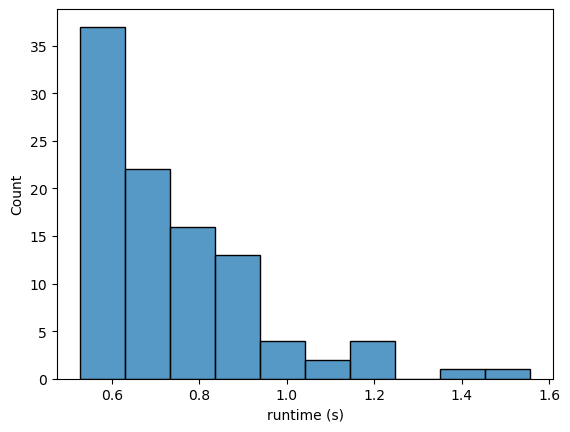

In [65]:
sns.histplot(data=results, x='runtime (s)');

In [66]:
results.describe()

,runtime (s),n_guidestars
count,100.000000,100.0
mean,0.735393,3.0
std,0.198460,0.0
min,0.525772,3.0
25%,0.583148,3.0
50%,0.688372,3.0
75%,0.831781,3.0
max,1.557090,3.0
